## Análise do Consumo Energético e Clustering de Consumidores

### Introdução

Este notebook aborda a análise de agrupamento (clustering) aplicada aos dados de consumo de energia. O objetivo principal é identificar padrões de consumo e segmentar os consumidores com base nos seus padrões de consumo de energia.

In [1]:
#import findspark
#findspark.init()
#findspark.find()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator 
import matplotlib.pyplot as plt 
from pyspark.ml import Pipeline

# build our SparkSession

spark = SparkSession\
        .builder\
        .appName("TrabalhoFinal")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

##### Função para Calcular Estatísticas de Energia

In [2]:
def compute_energy_stats(df):
    """
    Function to compute various energy statistics.

    Parameters:
    df (DataFrame): The input Spark DataFrame.

    Returns:
    DataFrame: The resulting DataFrame with aggregated statistics.
    """
    # Calculate overall consumption statistics
    overall_stats = df.groupBy("LCLid").agg(
        F.mean("energy(kWh/hh)").cast("float").alias("Consume_mean"),
        F.max("energy(kWh/hh)").cast("float").alias("Consume_max"),
        F.min("energy(kWh/hh)").cast("float").alias("Consume_min")
    )

    # Calculate mean consumption for each period of the day
    period_means = df.groupBy("LCLid").pivot("period_of_day").agg(
        F.mean("energy(kWh/hh)").cast("float").alias("Consume_mean")
    ).select(
        F.col("LCLid"),
        F.col("Morning").alias("Consume_mean_Morning"),
        F.col("Noon").alias("Consume_mean_Noon"),
        F.col("Evening").alias("Consume_mean_Evening"),
        F.col("Night").alias("Consume_mean_Night")
    )

    # Calculate minimum and maximum consumption day
    day_stats = df.groupBy("LCLid", "day").agg(
        F.sum("energy(kWh/hh)").cast("float").alias("daily_energy")
    ).groupBy("LCLid").agg(
        F.min("daily_energy").cast("float").alias("Min_Day"),
        F.max("daily_energy").cast("float").alias("Max_Day")
    )

    # Combine all statistics into one DataFrame
    final_df = overall_stats.join(period_means, on="LCLid", how="left") \
                            .join(day_stats, on="LCLid", how="left")

    return final_df



##### Carregamento dos Dados

In [4]:
dados_final = spark.read.parquet('dados_final_parquet')

In [5]:
dados_final = dados_final.withColumn('temperature', F.col('temperature').cast('float'))
dados_final = dados_final.withColumn('apparentTemperature', F.col('apparentTemperature').cast('float'))
dados_final = dados_final.withColumn('humidity', F.col('humidity').cast('float'))

dados_final.printSchema()


root
 |-- LCLid: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- energy(kWh/hh): string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- temperature: float (nullable = true)
 |-- apparentTemperature: float (nullable = true)
 |-- precipType: string (nullable = true)
 |-- humidity: float (nullable = true)
 |-- summary: string (nullable = true)
 |-- period_of_day: string (nullable = true)
 |-- weekend: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)



In [6]:
dados_final.show(10,truncate=False)

dados_final.count()

+---------+-------------------+--------------+--------+-------+-------------+-----------+-------------------+----------+--------+-------------+-------------+-------+-----+---+----+
|LCLid    |time               |energy(kWh/hh)|stdorToU|Acorn  |Acorn_grouped|temperature|apparentTemperature|precipType|humidity|summary      |period_of_day|weekend|month|day|hour|
+---------+-------------------+--------------+--------+-------+-------------+-----------+-------------------+----------+--------+-------------+-------------+-------+-----+---+----+
|MAC000071|2013-01-01 00:00:00| 0.113        |ToU     |ACORN-J|Comfortable  |7.01       |3.66               |rain      |0.73    |Partly Cloudy|Night        |0      |1    |1  |0   |
|MAC000071|2013-01-01 00:30:00| 0.062        |ToU     |ACORN-J|Comfortable  |7.01       |3.66               |rain      |0.73    |Partly Cloudy|Night        |0      |1    |1  |0   |
|MAC000071|2013-01-01 01:00:00| 0.107        |ToU     |ACORN-J|Comfortable  |7.49       |4.24  

93024229

##### Amostragem dos Dados
Df de teste (10% do original)

In [7]:
df_test = dados_final.sample(False, 0.1, seed=42)


In [8]:
df_test.count()

9303458

A amostra de 10% dos dados contém 9303458 registos.

In [9]:
df_test.select("LCLid").distinct().count()

5528

Dentro da amostra, há 5528 residências distintas (`LCLid`).

In [10]:
df_test_all = compute_energy_stats(df_test)
df_test_all.show(5, truncate=False,vertical=True)

df_test_all.count()

-RECORD 0---------------------------
 LCLid                | MAC000002   
 Consume_mean         | 0.24050856  
 Consume_max          | 2.201       
 Consume_min          | 0.066       
 Consume_mean_Morning | 0.19414712  
 Consume_mean_Noon    | 0.24366121  
 Consume_mean_Evening | 0.34832537  
 Consume_mean_Night   | 0.1683458   
 Min_Day              | 5.8         
 Max_Day              | 21.445      
-RECORD 1---------------------------
 LCLid                | MAC000003   
 Consume_mean         | 0.40956765  
 Consume_max          | 3.373       
 Consume_min          | 0.007       
 Consume_mean_Morning | 0.3045663   
 Consume_mean_Noon    | 0.16305761  
 Consume_mean_Evening | 0.16824828  
 Consume_mean_Night   | 0.9719261   
 Min_Day              | 10.63       
 Max_Day              | 35.855      
-RECORD 2---------------------------
 LCLid                | MAC000004   
 Consume_mean         | 0.03583039  
 Consume_max          | 0.473       
 Consume_min          | 0.0         
 

5528

### Modeling

Para preparar os dados para a modelação, foi necessário criar um vetor de características que representasse as variáveis relevantes para o nosso estudo. Para isso, selecionámos as seguintes variáveis: `Consume_mean`, `Consume_max`, `Consume_min`, `Consume_mean_Morning`, `Consume_mean_Noon`, `Consume_mean_Evening`, `Consume_mean_Night`, `Min_Day` e `Max_Day`. Estas variáveis foram então combinadas num único vetor de características utilizando a função VectorAssembler, que cria um novo vetor chamado 'features'. Para garantir a qualidade dos dados, foi utilizado o parametro `handleInvalid=skip`, que ignora quaisquer linhas com valores inválidos durante este processo. O resultado deste processo pode ser visualizado no DataFrame 'final_data', onde cada linha representa uma instância de dados e a coluna 'features' contém o vetor de características resultante.

In [11]:
inputCols= ['Consume_mean' ,'Consume_max' ,'Consume_min','Consume_mean_Morning' ,'Consume_mean_Noon','Consume_mean_Evening','Consume_mean_Night', 'Min_Day','Max_Day']
  
vec_assembler = VectorAssembler(inputCols=inputCols, outputCol='features', handleInvalid='skip')

# Transform the DataFrame
final_data = vec_assembler.transform(df_test_all)

final_data.show(5, truncate=False)


+---------+------------+-----------+-----------+--------------------+-----------------+--------------------+------------------+-------+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|LCLid    |Consume_mean|Consume_max|Consume_min|Consume_mean_Morning|Consume_mean_Noon|Consume_mean_Evening|Consume_mean_Night|Min_Day|Max_Day|features                                                                                                                                                                          |
+---------+------------+-----------+-----------+--------------------+-----------------+--------------------+------------------+-------+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|MAC000002|0.24050856  |2.201  

Após a criação do vetor de características, foi necessário normalizar os valores das características para garantir que todas as variáveis tenham a mesma escala. Para realizar esta normalização, utilizou-se a técnica de Min-Max Scaling, que redimensiona os valores das características para um intervalo específico (normalmente [0,1]).

Primeiro, inicializámos o MinMaxScaler especificando a coluna de entrada como 'features' e a coluna de saída como 'scaled_features'. Em seguida, ajustou-se o modelo de normalização aos dados de treino utilizando a função 'fit', que calcula as estatísticas resumidas necessárias para normalizar os dados. Posteriormente, aplicou-se a transformação de normalização aos dados de treino utilizando o modelo ajustado.

O resultado da normalização pode ser visualizado no DataFrame 'final_data', onde a coluna 'scaled_features' contém as características normalizadas para cada instância de dados.

In [12]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Compute summary statistics and generate MinMaxScalerModel
scaler_model = scaler.fit(final_data)

# Scale features
final_data = scaler_model.transform(final_data)

# Show the scaled features
final_data.select('scaled_features').show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                         |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.1031588766715947,0.22472943117521912,0.08375634604157832,0.09443738771012385,0.11691875633507302,0.1430966405579915,0.029815274374857276,0.07532956664505526,0.13294607595056449]    |
|[0.17567166740244497,0.3443945292549879,0.008883249144922946,0.14814767513277632,0.07824180559019428,0.0691186049800774,0.17213523685565302,0.13806090960770576,0.22227939194142657]    |
|[0.015368362809460218,0.04829487500819153,0.0,0.0155342881616259

In [98]:
silhouette_score=[] 

evaluator = ClusteringEvaluator(predictionCol='prediction', 
								featuresCol='scaled_features',
								metricName='silhouette', 
								distanceMeasure='squaredEuclidean') 

for i in range(2,10): 
	kmeans=KMeans(featuresCol='scaled_features', k=i, seed=123) 
	model=kmeans.fit(final_data) 
	predictions=model.transform(final_data) 
	score=evaluator.evaluate(predictions) 
	silhouette_score.append(score) 
	print('Silhouette Score for k =',i,'is',score)


Silhouette Score for k = 2 is 0.7080202507605187
Silhouette Score for k = 3 is 0.6185256534400146
Silhouette Score for k = 4 is 0.5479109502052396
Silhouette Score for k = 5 is 0.5033056660418879
Silhouette Score for k = 6 is 0.48531448276795314
Silhouette Score for k = 7 is 0.35533650942423667
Silhouette Score for k = 8 is 0.35513470268939007
Silhouette Score for k = 9 is 0.37043427235911874


Calculou-se o score de silhueta para cada k no intervalo de 2 a 9. O score de silhueta mede a coesão e a separação dos clusters, ajudando a determinar a qualidade da clusterização. Valores mais próximos de 1 indicam uma clusterização mais densa e bem separada.

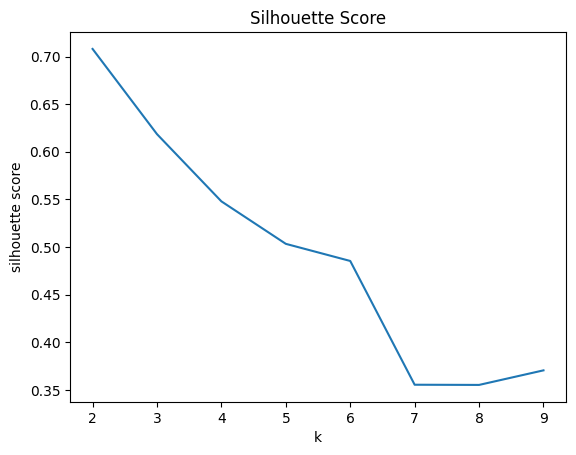

In [100]:
plt.plot(range(2,10),silhouette_score) 
plt.xlabel('k') 
plt.ylabel('silhouette score') 
plt.title('Silhouette Score') 
plt.show()

Com base na análise do gráfico de cotovelo, observa-se uma queda significativa no aumento do score de silhueta após k=3. Além disso, escolheu-se k=3 porque este valor proporciona um equilíbrio entre a separação adequada dos clusters e a complexidade do modelo. Portanto, decidiu-se selecionar k=3 como o número ideal de clusters para a análise.

Treina-se um modelo K-Means com 3 clusters usando os dados finais já normalizados. O algoritmo K-Means agrupará os dados em três clusters com base nas características contidas na coluna "scaled_features".

O modelo treinado é armazenado na variável "model", enquanto as previsões dos clusters para os dados de entrada são geradas e armazenadas na variável "predictions".

In [13]:

# Trains a k-means model. 
kmeans = KMeans(featuresCol='scaled_features',k=3, seed=123) 
model = kmeans.fit(final_data) 
predictions = model.transform(final_data)

Posteriormente, calculam-se os centros dos clusters gerados pelo modelo K-Means e cria-se um DataFrame para representá-los de forma mais organizada.

1. Primeiro, obtem-se os centros dos clusters usando o método `clusterCenters()` do modelo K-Means, armazenando-os na variável `centers`.
2. De seguida, itera-se sobre os centros dos clusters e cria-se um dicionário `row_data` para cada centro, onde as chaves correspondem aos nomes das características e os valores são os respectivos valores do centro.
3. Cada dicionário `row_data` é convertido num objeto `Row` e adicionado à lista `data`.
4. Define-se o esquema do DataFrame especificando os nomes das colunas e os tipos de dados.
5. Utilizando o esquema definido, cria-se um DataFrame chamado `cluster_centers_df` a partir da lista de dados `data`.
6. Por fim, exibe-se o DataFrame `cluster_centers_df`, que mostra os centros dos clusters com as características correspondentes em colunas separadas.

In [14]:
centers = model.clusterCenters() 
# List to hold the data
data = []

# Iterate over the cluster centers and create a Row for each center
for i, center in enumerate(centers):
    row_data = {
        "Consume_mean": float(center[0]),
        "Consume_max": float(center[1]),
        "Consume_min": float(center[2]),
        "Consume_mean_Morning": float(center[3]),
        "Consume_mean_Noon": float(center[4]),
        "Consume_mean_Evening": float(center[5]),
        "Consume_mean_Night": float(center[6]),
        "Min_Day": float(center[7]),
        "Max_Day": float(center[8])
    }
    # Append the Row to the data list
    data.append(Row(**row_data))

# Define the schema for the DataFrame
schema = StructType([
    StructField("Consume_mean", FloatType(), nullable=True),
    StructField("Consume_max", FloatType(), nullable=True),
    StructField("Consume_min", FloatType(), nullable=True),
    StructField("Consume_mean_Morning", FloatType(), nullable=True),
    StructField("Consume_mean_Noon", FloatType(), nullable=True),
    StructField("Consume_mean_Evening", FloatType(), nullable=True),
    StructField("Consume_mean_Night", FloatType(), nullable=True),
    StructField("Min_Day", FloatType(), nullable=True),
    StructField("Max_Day", FloatType(), nullable=True)
])

# Create DataFrame using the specified schema
cluster_centers_df = spark.createDataFrame(data, schema=schema)

# Show the DataFrame
cluster_centers_df.show()

+------------+-----------+-----------+--------------------+-----------------+--------------------+------------------+----------+-----------+
|Consume_mean|Consume_max|Consume_min|Consume_mean_Morning|Consume_mean_Noon|Consume_mean_Evening|Consume_mean_Night|   Min_Day|    Max_Day|
+------------+-----------+-----------+--------------------+-----------------+--------------------+------------------+----------+-----------+
|  0.05330972| 0.12908413|0.021310782|         0.057795502|       0.06503283|          0.06961891|      0.0130209215|0.04633711|0.061931286|
|   0.2937032|  0.3902783| 0.11512419|          0.32474813|        0.3505345|          0.35116425|        0.08608117|0.24990796| 0.32726064|
|  0.12606068| 0.24579746|0.050768673|          0.13470587|       0.15380688|          0.16171429|        0.03264286|0.11156876| 0.14771971|
+------------+-----------+-----------+--------------------+-----------------+--------------------+------------------+----------+-----------+



Calculo do coeficiente de silhueta para avaliar a qualidade dos clusters produzidos pelo modelo K-Means. Um valor próximo de 1 indica que os objetos estão bem agrupados, enquanto valores próximos de -1 indicam que os objetos estão mal agrupados.

Usou-se o `ClusteringEvaluator` para calcular o coeficiente de silhueta. 

In [22]:
silhouette = evaluator.evaluate(predictions) 
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6185256534400146


O resultado foi um coeficiente de silhueta de aproximadamente 0.619, indicando uma boa estruturação dos clusters. Isto sugere que os objetos dentro de cada cluster estão mais próximos uns dos outros do que dos objetos noutros clusters, o que é uma boa indicação da qualidade dos clusters formados pelo modelo K-Means.

### PIPELINE

Criação de um pipeline para agrupar várias etapas do processamento de dados. 

1. **Definição das Etapas do Pipeline:**
   - `preprocessing_stage`: Utiliza o `VectorAssembler` para criar um conjunto de características a partir das colunas especificadas em `inputCols`, e resulta numa nova coluna chamada 'features'.
   - `scaling_stage`: Utiliza o `MinMaxScaler` para dimensionar as características para um intervalo específico, criando uma nova coluna chamada 'scaled_features'.
   - `clustering_stage`: Configura o modelo de K-Means para realizar a tarefa de agrupamento com base nas características escaladas.

2. **Construção do Pipeline:**
   - `pipeline`: Encadeia as etapas de pré-processamento, normalização e agrupamento.

3. **Treino do Pipeline:**
   - `pipeline_model`: Treina o pipeline utilizando os dados de treino `df_test_all`.

4. **Salvar o Modelo Treinado:**
   - `pipeline_model.save('clustering_model')`: Guarda o modelo treinado, que inclui todas as etapas do pipeline, para uso futuro.

Este pipeline permite pré-processar, dimensionar e agrupar novos dados de acordo com a mesma estrutura aplicada aos dados de treino, assegurando consistência e reprodutibilidade no processo de agrupamento.

In [130]:
# Define the data preprocessing stage
preprocessing_stage =  VectorAssembler(inputCols=inputCols, outputCol='features', handleInvalid='skip')

# Define the scaling stage
scaling_stage = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Define the clustering stage
clustering_stage = KMeans(featuresCol='scaled_features', k=3, seed=123)


# Build the pipeline
pipeline = Pipeline(stages=[preprocessing_stage, scaling_stage, clustering_stage])



In [ ]:
# Define the directory path
pipeline_path = "clustering_pipeline"

# Save the pipeline
pipeline.save(pipeline_path)



In [133]:
# Fit the pipeline to the data
pipeline_model = pipeline.fit(df_test_all)

pipeline_model.save('clustering_model')